# Study an integral

In [1]:
%%writefile task_07_utils.py

import numpy as np

def f(x):
    return (1 / 10) * (np.log(x) / 2) ** np.sin(x)

def trapezoidal_rule_integration(samples, discretization_step):
    y = f(samples)
    y_right = y[1:] # right endpoints
    y_left = y[:-1] # left endpoints
    dx = (samples[-1] - samples[0])/(samples.size)
    return (dx/2) * np.sum(y_right + y_left)

Overwriting task_07_utils.py


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from task_07_utils import *
from matplotlib.patches import Polygon

$$f(x) = \frac{1}{10} \left( \frac{\lg(x)}{2} \right)^{\sin(x)}$$
$$\int_{16.5}^{27} \frac{1}{10} \left( \frac{\lg(x)}{2} \right)^{\sin(x)} \,dx = 1.09613$$

In [3]:
analytical_ans = 1.09613

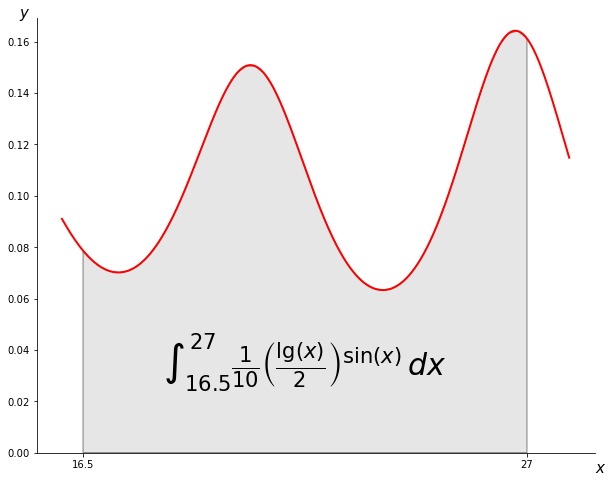

In [4]:
a, b = 16.5, 27  # integral limits
x = np.linspace(16, 28, 1000)
y = f(x)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x, y, 'r', linewidth=2)
ax.set_ylim(bottom=0)

# Make the shaded region
ix = np.linspace(a, b)
iy = f(ix)
verts = [(a, 0), *zip(ix, iy), (b, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly)

ax.text(0.5 * (a + b), 0.03,
        r"$\int_{16.5}^{27} \frac{1}{10} \left( \frac{\lg(x)}{2} \right)^{\sin(x)} \,dx$",
        horizontalalignment='center', fontsize=30)

fig.text(0.9, 0.09, '$x$', fontsize=15)
fig.text(0.1, 0.88, '$y$', fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticks((a, b))
ax.set_xticklabels((f'{a}', f'{b}'))

plt.show()

Error function:

$$\text{SE} = \left(Y - \hat{Y}\right)^2$$

In [5]:
discretization_size = np.arange(1, 100_000, dtype=int)

squared_error = np.empty(discretization_size.size, dtype=float)
discretization_steps = np.empty(discretization_size.size, dtype=float)

for i, size in enumerate(discretization_size):
    samples, discretization_step = np.linspace(16.5, 27, num=size, retstep=True)
    squared_error[i] = (trapezoidal_rule_integration(samples, discretization_step) - analytical_ans) ** 2
    discretization_steps[i] = discretization_step

Text(0.5, 0.98, 'Integration error vs discretization step')

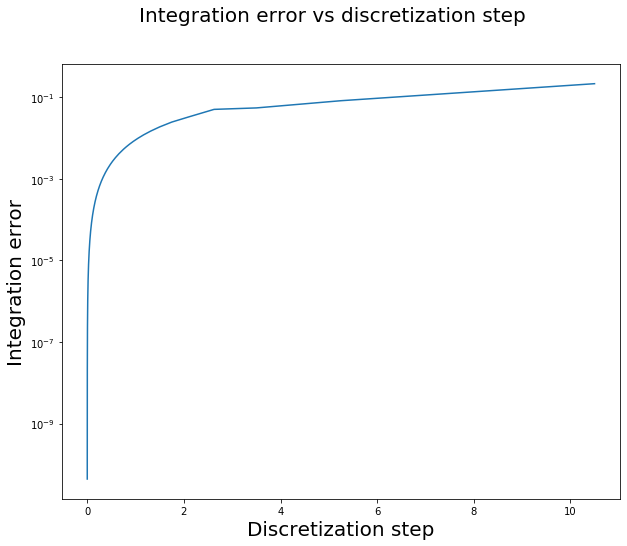

In [6]:
plt.figure(figsize=(10, 8))
plt.semilogy(discretization_steps, squared_error)
plt.xlabel('Discretization step', fontsize=20)
plt.ylabel('Integration error', fontsize=20)
plt.suptitle('Integration error vs discretization step', fontsize=20)

### MPI

In [7]:
%%writefile task_07_integral.py

import os
import time
import numpy as np

from PIL import Image
from mpi4py import MPI
from task_07_utils import *


comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

IS_ROOT = rank == 0
IS_SAVE = False

LOWER_BOUND = 16.5
UPPER_BOUND = 27
LINSPACE_SIZE = 100_000_000

discretization_step = None
samples = None
array_size = None

if IS_ROOT:
    samples, discretization_step = np.linspace(LOWER_BOUND, UPPER_BOUND, num=LINSPACE_SIZE, retstep=True, dtype=float)
    array_size = samples.size
    
array_size = comm.bcast(array_size, root=0)
discretization_step = comm.bcast(discretization_step, root=0)
num_data_per_rank = array_size // size

if IS_ROOT:
    num_data_per_rank =  array_size - (num_data_per_rank * (size - 1))

received = np.empty(num_data_per_rank, dtype=float)
sendcounts = np.array(comm.gather(num_data_per_rank, 0))

comm.Scatterv((samples, sendcounts), received, root=0)
received_calc = trapezoidal_rule_integration(received, discretization_step)

answer = comm.reduce(received_calc, op=MPI.SUM, root=0)

Overwriting task_07_integral.py


In [8]:
time_arr = []
processes = range(1, 12)
for i in processes:
    print(f'{i} process(es)\n\t', end='')
    t = %timeit -o -r 3 !mpirun -n {i} --allow-run-as-root --mca btl ^vader python3 task_07_integral.py
    time_arr.append(t.best)

1 process(es)
	4.55 s ± 28.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2 process(es)
	2.92 s ± 15.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3 process(es)
	2.44 s ± 17.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
4 process(es)
	2.15 s ± 15.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
5 process(es)
	1.98 s ± 42.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
6 process(es)
	1.89 s ± 27.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
7 process(es)
	1.79 s ± 41.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
8 process(es)
	1.78 s ± 42.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
9 process(es)
	1.68 s ± 5.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
10 process(es)
	1.69 s ± 28.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
11 process(es)
	1.72 s ± 55.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Text(0.5, 0.98, 'SpeedUp vs Num of processes')

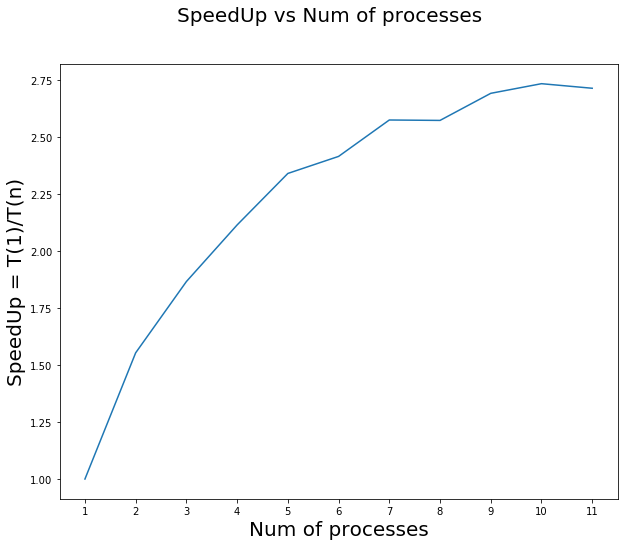

In [9]:
speedup = time_arr[0] / np.array(time_arr)

plt.figure(figsize=(10, 8))
plt.plot(processes, speedup)
plt.xticks(processes)
plt.xlabel('Num of processes', fontsize=20)
plt.ylabel('SpeedUp = T(1)/T(n)', fontsize=20)
plt.suptitle('SpeedUp vs Num of processes', fontsize=20)